# Mutation Testing Deep Analysis

This notebook analyzes the mutation testing reports generated by Stryker for various projects. The goal is to identify trends, hotspots (files with many surviving mutants), and the effectiveness of different mutators.

In [8]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set plot style roughly to somewhat standard
plt.style.use('ggplot')
%matplotlib inline

## 1. Data Loading

We will load all JSON reports from the `reports/` directory. Each report corresponds to a project.

In [9]:
report_files = glob.glob('reports/*.json')
print(f"Found {len(report_files)} reports: {report_files}")

all_mutants = []

for report_path in report_files:
    project_name = os.path.basename(report_path).replace('.json', '')
    print(f"Processing {project_name}...")
    
    with open(report_path, 'r', encoding='utf-8') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Skipping {project_name} due to JSON error")
            continue
            
    files = data.get('files', {})
    for file_path, file_data in files.items():
        mutants = file_data.get('mutants', [])
        for mutant in mutants:
            mutant_info = {
                'project': project_name,
                'file_path': file_path,
                'files_surviving': 0, # Placeholder, calculation logic differs
                'mutator_name': mutant.get('mutatorName'),
                'status': mutant.get('status'),
                'replacement': mutant.get('replacement'),
                'id': mutant.get('id')
            }
            all_mutants.append(mutant_info)

df = pd.DataFrame(all_mutants)
print(f"Loaded {len(df)} mutants total.")
df.head()

Found 8 reports: ['reports/dayjs.json', 'reports/ms.json', 'reports/jest-native.json', 'reports/react-testing-library.json', 'reports/projector-example-ts.json', 'reports/js-utils.json', 'reports/nodejs-getting-started.json', 'reports/commander.json']
Processing dayjs...
Processing ms...
Processing jest-native...
Processing react-testing-library...
Processing projector-example-ts...
Processing js-utils...
Processing nodejs-getting-started...
Processing commander...
Loaded 16557 mutants total.


,project,file_path,files_surviving,mutator_name,status,replacement,id
0,dayjs,src/constant.js,0,StringLiteral,Killed,"""""",8
1,dayjs,src/constant.js,0,StringLiteral,Killed,"""""",9
2,dayjs,src/constant.js,0,StringLiteral,Killed,"""""",10
3,dayjs,src/constant.js,0,StringLiteral,Killed,"""""",11
4,dayjs,src/constant.js,0,StringLiteral,Killed,"""""",12


## 2. Data Cleaning & Metrics

We calculate the Mutation Score. Typically:
$$ Mutation Score = \frac{Killed + Timeout + Error}{Total - CompileError} $$

For simplicity here:
- **Killed**: 'Killed', 'Timeout', 'Error'
- **Survived**: 'Survived', 'NoCoverage'

In [10]:
# Normalize status for score calculation
def is_killed(status):
    return status in ['Killed', 'Timeout', 'Error']

df['is_killed'] = df['status'].apply(is_killed)
df['is_survived'] = df['status'].isin(['Survived', 'NoCoverage'])

print("Status Breakdown:")
print(df['status'].value_counts())

Status Breakdown:
status
Killed          8848
Survived        6727
NoCoverage       529
Timeout          252
RuntimeError     201
Name: count, dtype: int64


## 3. Global Analysis: Project vs Score

Which projects have the best test coverage?

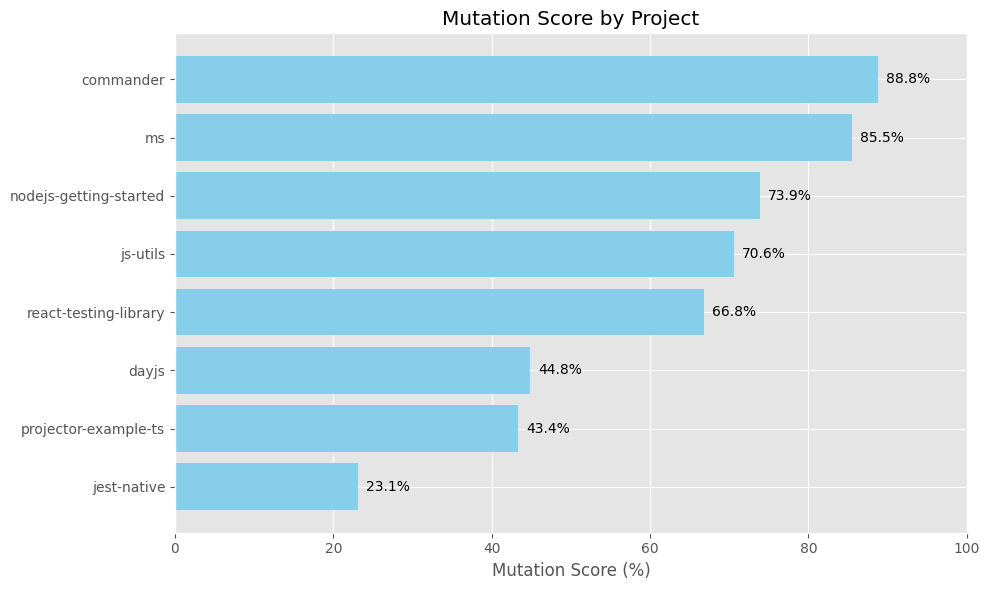

In [11]:
project_stats = df.groupby('project').agg(
    total_mutants=('id', 'count'),
    killed_mutants=('is_killed', 'sum')
).reset_index()

project_stats['mutation_score'] = (project_stats['killed_mutants'] / project_stats['total_mutants']) * 100
project_stats = project_stats.sort_values('mutation_score', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(project_stats['project'], project_stats['mutation_score'], color='skyblue')
plt.xlabel('Mutation Score (%)')
plt.title('Mutation Score by Project')
plt.xlim(0, 100)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center')

plt.tight_layout()
plt.show()

## 4. Correlation Analysis: Does Code Size Affect Quality?

We use 'total_mutants' as a proxy for code volume/complexity. A higher number of mutants generally indicates more code.

**Hypothesis**: Does a larger codebase imply lower mutation scores (harder to test) or higher scores (more mature)?

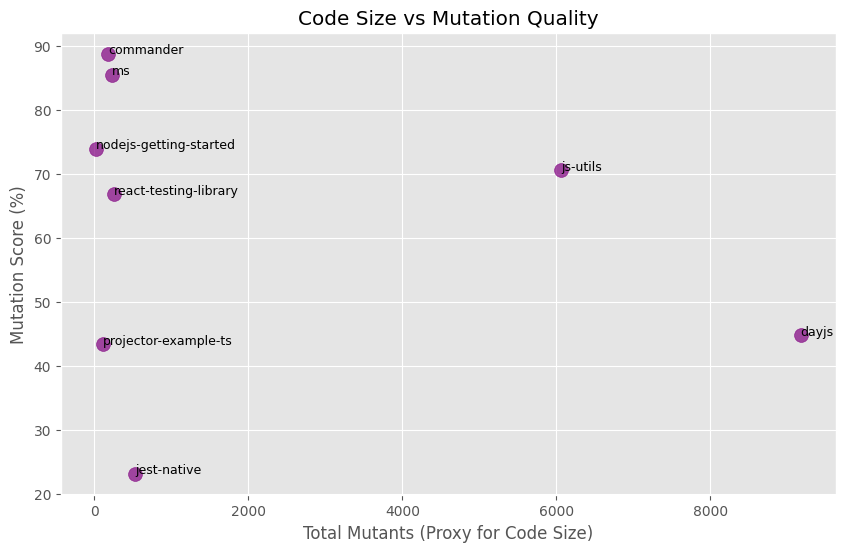

Correlation between Total Mutants and Mutation Score: -0.21


In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(project_stats['total_mutants'], project_stats['mutation_score'], color='purple', s=100, alpha=0.7)

for i, row in project_stats.iterrows():
    plt.text(row['total_mutants'], row['mutation_score'], row['project'], fontsize=9)

plt.xlabel('Total Mutants (Proxy for Code Size)')
plt.ylabel('Mutation Score (%)')
plt.title('Code Size vs Mutation Quality')
plt.grid(True)
plt.show()

# Calculate correlation
correlation = project_stats['total_mutants'].corr(project_stats['mutation_score'])
print(f"Correlation between Total Mutants and Mutation Score: {correlation:.2f}")

## 5. Mutator Effectiveness

Which types of mutations are hardest to kill? High survival rate means tests often miss this logic.

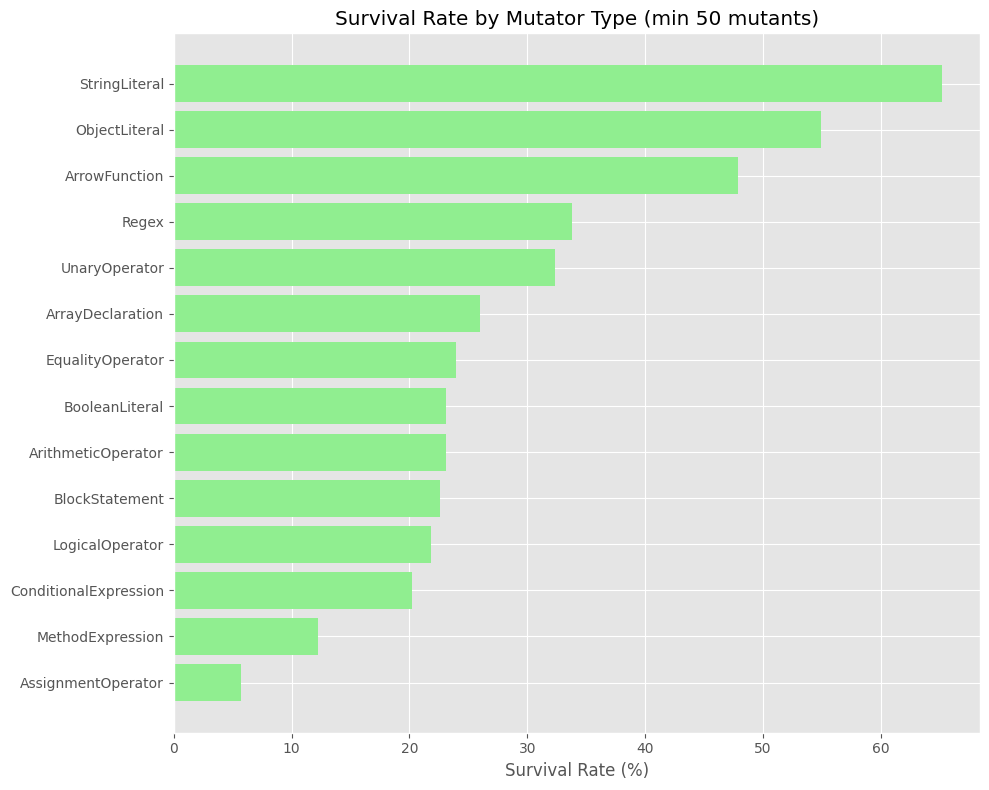

In [13]:
mutator_stats = df.groupby('mutator_name').agg(
    total=('id', 'count'),
    survived=('is_survived', 'sum')
).reset_index()

mutator_stats['survival_rate'] = (mutator_stats['survived'] / mutator_stats['total']) * 100
# Filter out rare mutators to avoid noise
mutator_stats = mutator_stats[mutator_stats['total'] > 50].sort_values('survival_rate', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(mutator_stats['mutator_name'], mutator_stats['survival_rate'], color='lightgreen')
plt.xlabel('Survival Rate (%)')
plt.title('Survival Rate by Mutator Type (min 50 mutants)')
plt.tight_layout()
plt.show()

## 6. Project Details Table

Detailed breakdown for every project.

In [14]:
details = df.groupby('project').agg(
    total=('id', 'count'),
    killed=('is_killed', 'sum'),
    survived=('is_survived', 'sum')
).reset_index()
details['score'] = (details['killed'] / details['total'] * 100).round(2)
details.sort_values('score', ascending=False)

,project,total,killed,survived,score
0,commander,178,158,2,88.76
4,ms,227,194,33,85.46
5,nodejs-getting-started,23,17,6,73.91
3,js-utils,6065,4280,1644,70.57
7,react-testing-library,253,169,78,66.80
1,dayjs,9171,4111,5024,44.83
6,projector-example-ts,113,49,64,43.36
2,jest-native,527,122,405,23.15
